In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew

%matplotlib inline

In [3]:
train = pd.read_csv("train.csv", index_col = 0)
test = pd.read_csv("test.csv", index_col = 0)

In [4]:
print(train.shape)
print(test.shape)

(1460, 80)
(1459, 79)


In [5]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
X = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                test.loc[:,'MSSubClass':'SaleCondition']))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000027EC87D49B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000027EC82F3EF0>]], dtype=object)

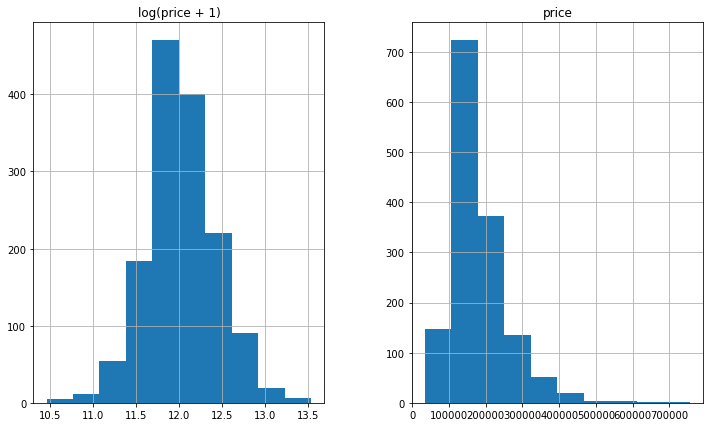

In [7]:
matplotlib.rcParams['figure.figsize'] = (12.0, 7.0)
prices = pd.DataFrame({"price":train["SalePrice"], "log(price + 1)":np.log1p(train["SalePrice"])})
prices.hist()

In [8]:
#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])

#log transform skewed numeric features:
numeric_feats = X.dtypes[X.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewness = skewed_feats[skewed_feats > 0.75]
X_Index = skewness.index

X[X_Index] = np.log1p(X[X_Index])
print(X_Index)

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


In [9]:
#convert categorical variable into dummy/indicator variables, like one-hot code
X = pd.get_dummies(X) 

#filling NAN's with the mean of the column:
X = X.fillna(X.mean())

#creating matrices for sklearn:
nt = train.shape[0]
ntr = nt // 2
nts = nt - ntr
X_train = X[:nt]
xtr = X_train[:ntr]
xts = X_train[ntr:]
y_train = train.SalePrice
ytr = y_train[:ntr]
yts = y_train[ntr:]

X_test = X[nt:]

In [10]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit(xtr, ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [11]:
yts_hat = regr.predict(xts)
RSS = np.mean((yts_hat - yts)**2) / (np.std(yts)**2)
print(RSS)
# The value seems good. Now we try to set regularization to avoid overfit

0.1819290900891748


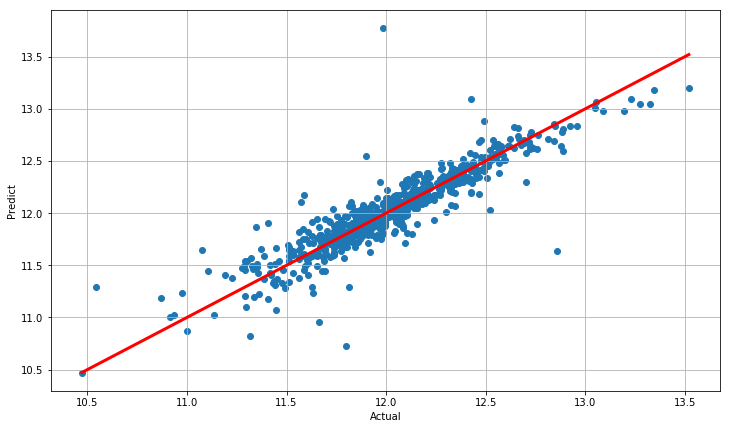

In [12]:
ymin = np.min(yts)
ymax = np.max(yts)
plt.scatter(yts, yts_hat)
plt.plot([ymin, ymax], [ymin, ymax], 'r-', linewidth = 3)
plt.grid()
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.show()

In [13]:
import  sklearn.model_selection
Xs = sklearn.preprocessing.scale(X_train)
ys = sklearn.preprocessing.scale(y_train)

nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Create the LASSO model.
model = linear_model.Lasso(warm_start=True)

# Regularization values to test
nalpha = 100
alphas = np.logspace(-3,0,nalpha)

# MSE for each alpha and fold value
mse = np.zeros((nalpha,nfold))
for ifold, ind in enumerate(kf.split(Xs)):
    
    
    # Get the training data in the split
    Itr,Its = ind
    Xs_tr = Xs[Itr,:]
    ys_tr = ys[Itr]
    Xs_ts = Xs[Its,:]
    ys_ts = ys[Its]
    
    # Compute the lasso path for the split
    for ia, a in enumerate(alphas):
        
        # Fit the model on the training data
        model.alpha = a
        model.fit(Xs_tr,ys_tr)
        
        # Compute the prediction error on the test data
        ys_ts_pred = model.predict(Xs_ts)
        mse[ia,ifold] = np.mean((ys_ts_pred-ys_ts)**2)

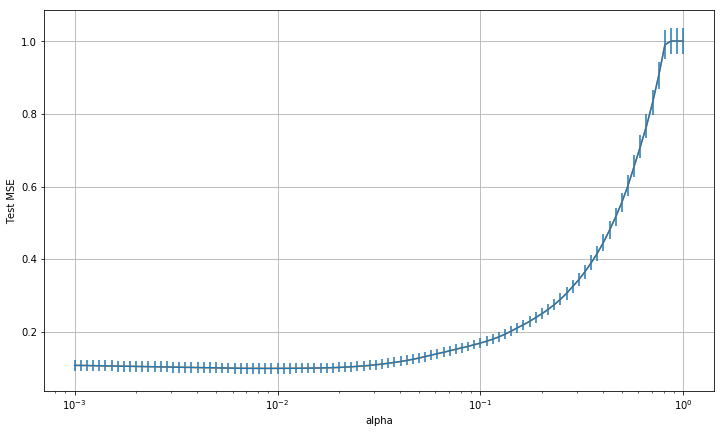

In [14]:
mse_mean = np.mean(mse,axis=1)
mse_std  = np.std(mse,axis=1) / np.sqrt(nfold-1)
plt.errorbar(alphas, mse_mean, yerr=mse_std, fmt='-')
plt.semilogx(alphas, mse_mean)
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.grid()

Optimal alpha = 0.035112
RSS = 0.099551


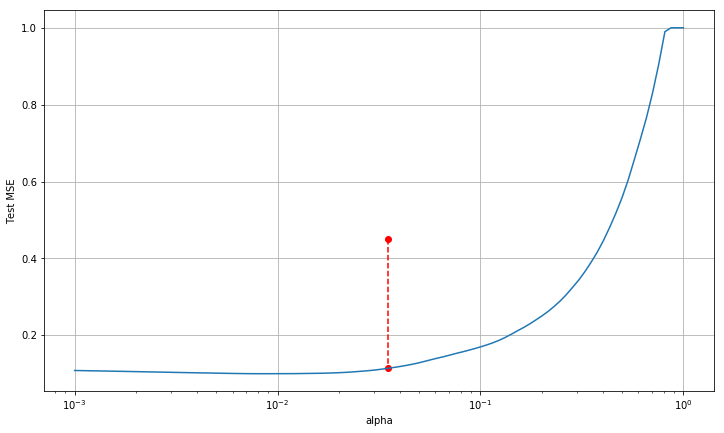

In [15]:
# Find the minimum MSE and MSE target
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_std[imin]
alpha_min = alphas[imin]

# Find the least complex model with mse_mean < mse_tgt
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)
print("RSS = %f" % mse_mean[imin])

plt.semilogx([alpha_opt,alpha_opt], [0.45,mse_mean[iopt]], 'ro--')
plt.semilogx(alphas, mse_mean,)
plt.xlabel('alpha')
plt.ylabel('Test MSE')
plt.grid()
plt.show()

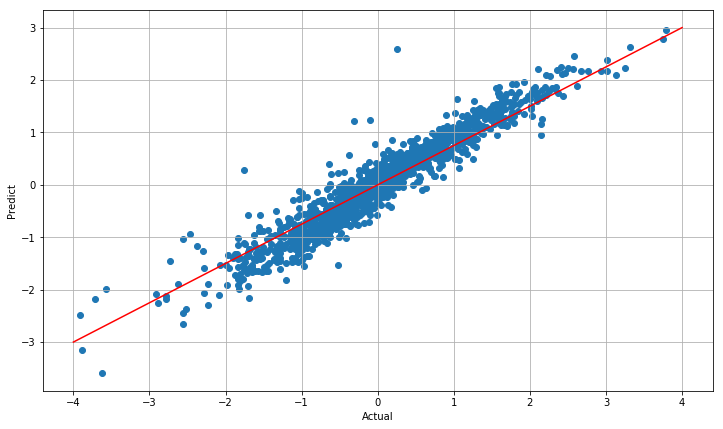

In [16]:
# The result seems better
model.alpha = alpha_opt        
model.fit(Xs,ys)
ys_pred = model.predict(Xs)
mse = np.mean((ys_ts_pred-ys_ts)**2)
plt.scatter(ys,ys_pred)
plt.plot([-4,4],[-3,3],'r')
plt.xlabel('Actual')
plt.ylabel('Predict')
plt.grid()
plt.show()